## Full-batch GD vs Mini-batch GD vs Stochastic GD
- Full-batch GD: use all training examples in each iteration
- Mini-batch SGD: use a subset of training examples in each iteration
  - Mini-batch size: 1 < m < n
  - in each iteration, use m training examples
  - but in each epoch, use all the batches
- SGD: use one training example in each iteration
  - SGD is a special case of mini-batch SGD
  - m = 1

#### side notes
- in Tensorflow the `SGD` optimizer is the Minibatch gradient descent, set the `batch_size` to 1 to get the correct SGD algorithm
- Adam optimizer is a mix of RMSProp and Momentum  

In [1]:
%load_ext autoreload
%autoreload 2

import functions as fn
from math import sqrt, floor, ceil
from typing import List, Tuple, Callable
import random
from numba import jit
SEED = 5


In [2]:

def Gradient_decent(
    xp: float,
    yp: float,
    data_x: List[float],
    data_y: List[float],
    lossfn : Callable,
    optimizer : Callable,
    N: int = 1000,
    batch_size=32,
    Lr: float = 0.01,
    seed=5,
) -> Tuple[float, float, float]:
    """performs gradient descent on the loss function numerically, using for loops

    Args:
        xp (float): x coordinate of the point
        yp (float): y coordinate of the point
        data_x (List[float]): list of x coordinates of the points
        data_y (List[float]): list of y coordinates of the points
        N (int): number of points. Defaults to 1000.
        batch_size (int): size of the batch. Defaults to 32.
        Lr (float): learning rate. Defaults to 0.01.
        seed (int): seed for the random generator. Defaults to 5.

    Returns:
        loss (float): the loss of the last epoch
        xp (float): the x coordinate of the last epoch
        yp (float): the y coordinate of the last epoch
    """

    # * to suffle the data but with reproducibility
    sampler = random.Random(seed)
    indicies = list(range(N))
    sampler.shuffle(indicies)
    # * calulate the number of iterations, data / batch_size
    Num_iterations = ceil(N / batch_size)
    epoch_loss = 0
    # print(f"Num_iterations: {Num_iterations}")

    for batch_idx in range(Num_iterations):
        # * question why didn't give error at [1000: 1001]?
        # * because it's a list, and it's not out of range
        batch_indicies = indicies[batch_size * batch_idx : batch_size * (batch_idx + 1)]

        # * get the batch
        batch_x = [data_x[i] for i in batch_indicies]
        batch_y = [data_y[i] for i in batch_indicies]

        # * compute the loss, accumulate it
        epoch_loss +=lossfn(xp, yp, batch_x, batch_y)

        # * compute the gradient
        grad_x, grad_y = optimizer(x_p=xp, y_p=yp, data_x=batch_x, data_y=batch_y)

        # * update the parameters
        xp = xp - Lr * grad_x
        yp = yp - Lr * grad_y

    # * average the loss over the number of iterations
    epoch_loss /= Num_iterations

    return epoch_loss, xp, yp

    # print(batch_indicies)

In [3]:

def fit(
    xp: float,
    yp: float,
    data_x: List[float],
    data_y: List[float],
    lossfn : Callable,
    optimizer : Callable,
    gradient_decent_type: str = "minibatch",
    EPOCHS: int = 100,
    BATCH_SIZE: int = 32,
    Lr: float = 0.01,
    seed=SEED,
    show_progress: bool = False,
) -> Tuple[List[float], List[float], List[float]]:
    """Fits Point to the data, using different gradient decent types

    Args:
        xp (float): x coordinate of the point
        yp (float): y coordinate of the point
        data_x (List[float]): x coordinates of the data
        data_y (List[float]): y coordinates of the data
        gradient_decent_type (str, optional): type of gradient decent. Defaults to "minibatch".
        EPOCHS (int, optional): number of epochs. Defaults to 100.
        BATCH_SIZE (int, optional): size of the batch. Defaults to 32, set to 1 for stochastic gradient decent
            and to len(data_x) for fullbatch gradient decent.
        Lr (float, optional): learning rate for the oprimization. Defaults to 0.01.
        seed (_type_, optional): reproducibility. Defaults to SEED.
        show_progress (bool, optional): show progress. Defaults to False.

    Returns:
        losses (List[float]): list of updated losses
        xp_vals (List[float]): list of updated x coordinates of the point
        yp_vals (List[float]): list of updated y coordinates of the point
    """

    if gradient_decent_type == "minibatch":
        BATCH_SIZE = BATCH_SIZE
    elif gradient_decent_type == "stochastic":
        BATCH_SIZE = 1
    elif gradient_decent_type == "fullbatch" or gradient_decent_type == "batch":
        BATCH_SIZE = len(data_x)
    Losses = []
    xp_vals = []
    yp_vals = []

    for Epoch in range(EPOCHS):
        loss, xp, yp = Gradient_decent(
            xp=xp,
            yp=yp,
            data_x=data_x,
            data_y=data_y,
            lossfn=lossfn,
            optimizer=optimizer,
            batch_size=BATCH_SIZE,
            Lr=Lr,
            seed=seed,
        )
        Losses.append(loss)
        xp_vals.append(xp)
        yp_vals.append(yp)
        if show_progress:
            if Epoch % (EPOCHS // 10) == 0 or Epoch == EPOCHS - 1:
                print(f"Epoch: {Epoch}, Loss: {loss}, xp: {xp}, yp: {yp}")
    return Losses, xp_vals, yp_vals

C:\Users\DELL\AppData\Local\Temp\ipykernel_21736\1210340675.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn")


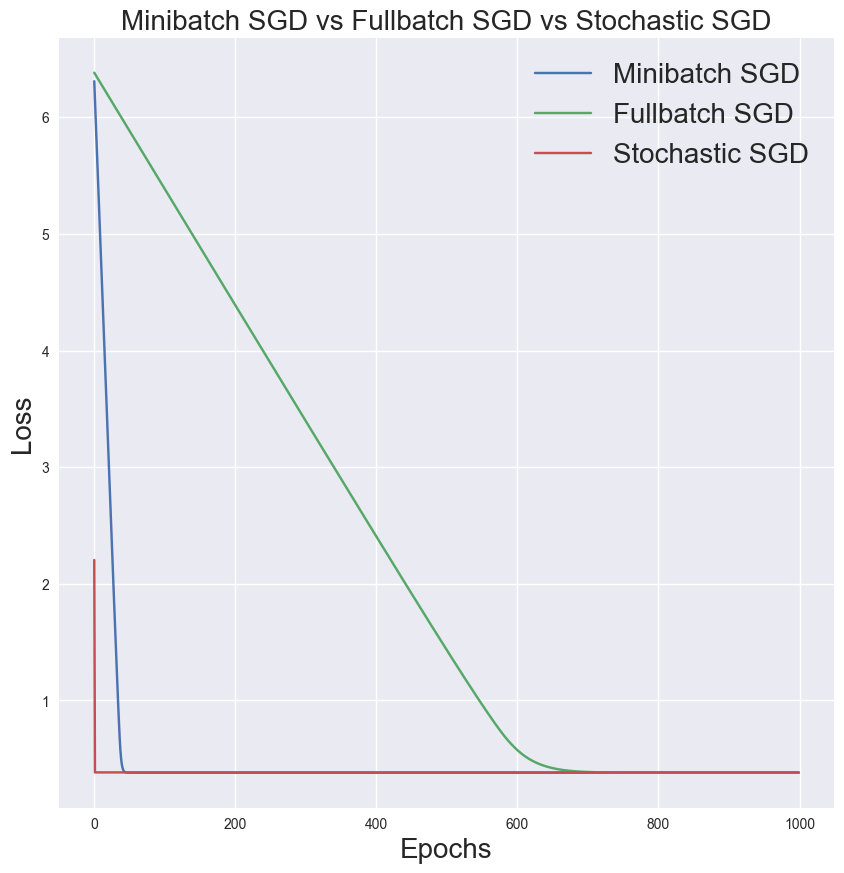

In [4]:
SEED = 1234
N = 1000  # * length of dataset
Lr = 0.01  # * learning rate
EPOCHS = 1000  # * number of epochs
data_x, data_y = fn.gen_pts_(N)
xp_mb, yp_mb = xp_fb, yp_fb = xp_sgd, yp_sgd = xp, yp = 5, 5  # * initial point
BATCH_SIZE = 64

#* adjust the learning rate, and the batch size to see the effect and the speed of convergence

mb_losses, mb_xps, mb_yps = fit(
    xp=xp_mb,
    yp=yp_fb,
    data_x=data_x,
    data_y=data_y,
    lossfn=fn.loss,
    optimizer=fn.calc_grad,
    gradient_decent_type="minibatch",
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    Lr=Lr,
    seed=SEED,
)

fb_losses, fb_xps, fb_yps = fit(
    xp=xp_fb,
    yp=yp_fb,
    data_x=data_x,
    data_y=data_y,
    lossfn=fn.loss,
    optimizer=fn.calc_grad,
    gradient_decent_type="fullbatch",
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    Lr=Lr,
    seed=SEED,
)

sgd_losses, sgd_xps, sgd_yps = fit(
    xp=xp_sgd,
    yp=yp_sgd,
    data_x=data_x,
    data_y=data_y,
    lossfn=fn.loss,
    optimizer=fn.calc_grad,
    gradient_decent_type="stochastic",
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    Lr=Lr,
    seed=SEED,
)


from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use("seaborn")
fig = plt.figure(figsize=(10, 10), dpi=100)
plt.title(f"Minibatch SGD vs Fullbatch SGD vs Stochastic SGD", fontsize=20)
plt.plot(mb_losses, label="Minibatch SGD")
plt.plot(fb_losses, label="Fullbatch SGD")
plt.plot(sgd_losses, label="Stochastic SGD")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(fontsize=20)
plt.show()

## closer look at Mini-batch GD and Stochastic GD



C:\Users\DELL\AppData\Local\Temp\ipykernel_21736\486918258.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn")


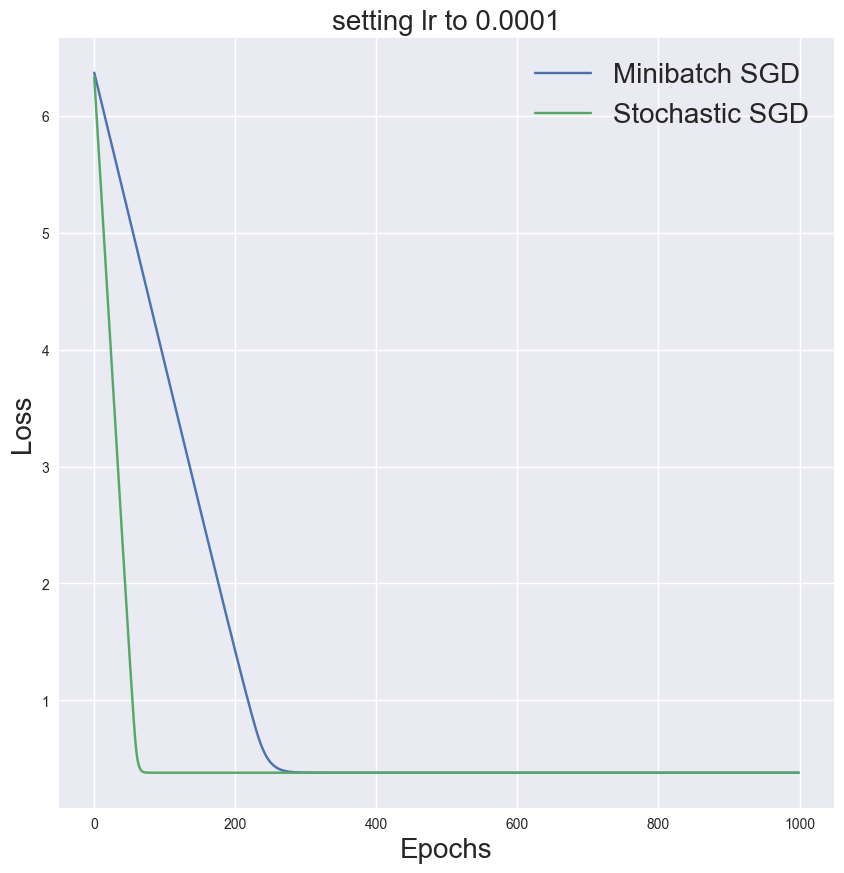

In [5]:
SEED = 1234
N = 1000  # * length of dataset
Lr = 1e-4  # * learning rate
EPOCHS = 1000  # * number of epochs
data_x, data_y = fn.gen_pts_list_comp_(N)
xp_test, yp_test= 0.3, 0.3  # * initial point
BATCH_SIZE = 4



mb_losses, mb_xps, mb_yps = fit(
    xp=xp_mb,
    yp=yp_fb,
    data_x=data_x,
    data_y=data_y,
    lossfn=fn.loss,
    optimizer=fn.calc_grad,
    gradient_decent_type="minibatch",
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    Lr=Lr,
    seed=SEED,
)

sgd_losses, sgd_xps, sgd_yps = fit(
    xp=xp_sgd,
    yp=yp_sgd,
    data_x=data_x,
    data_y=data_y,
    lossfn=fn.loss,
    optimizer=fn.calc_grad,
    gradient_decent_type="stochastic",
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    Lr=Lr,
    seed=SEED,
)
mpl.style.use("seaborn")
fig = plt.figure(figsize=(10, 10), dpi=100)
plt.title(f"setting lr to {Lr}", fontsize=20)
plt.plot(mb_losses, label="Minibatch SGD")
plt.plot(sgd_losses, label="Stochastic SGD")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Comments 
- Full-batch GD is smooth, but it's slow
- Stochastic GD and Mini-batch GD are noisy, but they're fast
- keep in mind that in the leacture prof. mina didn't calculate the avg loss per epoch, which is a mistake and he said that in the interactive session
- Minibatch and Stochastic GD are not guaranteed to converge to the global minimum, but they usually end up close to it
- Mini-batch GD & Stochastic GD are much faster than Full-batch GD
- Tunning lr and the number of epoches is important.
  - the smaller the lr the smaller the steps and the longer it takes to converge
  - the larger the lr the larger the steps and the more likely to miss the global minimum
  - very large lr can cause the loss to diverge, aka overshooting
